Based on [Classify Text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en) tutorial.

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Dataset preparation

The dataset used is IMDB reviews dataset (available at [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)).

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file(
        'aclImdb_v1.tar.gz', url,
        untar=True, cache_dir='.',
        cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Now the dataset is downloaded, the `text_dataset_from_directory` utillity can be used to create a labeled `tf.data.Dataset`.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2021-12-09 09:33:24.959280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 09:33:24.993889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-09 09:33:24.993910: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-09 09:33:25.021760: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

20% of the training data will be used to validation (the dataset has train and test sets but lacks a validation set).

In [5]:
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [6]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


Checking out some of the reviews:

In [7]:
for text_batch, label_batch in train_ds.take(1):
    # we'll print 3 reviews from the batch
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')
        print()

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as the

2021-12-09 09:33:26.014613: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models (using `tfhub`)

A BERT model may be downloaded from the [tensorflow hub](https://tfhub.dev/google/collections/bert/1) along with the preprocessing pipeline used.

The architecture of choice will be Small BERT - the same as BERT but with a reduced size.

In [8]:
# Number of attention heads
A = 2

# Number of layers (i.e., residual blocks)
L = 2

# Size of hidden layers
H = 128

tfhub_handle_encoder = f"https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-{L}_H-{H}_A-{A}/2"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## The preprocessing model

Along with the BERT model, TensorFlow hub provides a preprocessing model, which implements the proper transformation from text to token ids tensors using the `tensorflow_text` library.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## The BERT model

Similarly, the model can be loaded from the hub:

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999945   0.1434197  -0.9989779   0.9951449  -0.99974567  0.9131291
 -0.9961582  -0.97097486  0.09740011  0.0190706  -0.84881747 -0.0938554 ]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.43723714 -1.0138292  -2.3744743  ... -0.75897086 -2.091031
  -0.2580994 ]
 [-1.3369713  -0.36880246  0.5786883  ... -2.1810167  -1.7530919
  -0.09555051]
 [-1.0607047  -0.30371037  0.34461257 ... -1.2898585  -1.9519892
  -0.12230362]
 ...
 [-0.8602277  -0.5440615   0.65837353 ... -1.4765682  -1.7518611
   1.1197377 ]
 [-0.46869    -0.57152385  0.67256624 ... -1.7302344  -1.9740782
   0.9747924 ]
 [ 0.02036591 -0.75511825  0.5948236  ... -1.9656788  -1.9051433
   0.489703  ]]


The model outputs three important values:

- `pooled_output`: Represents the sentence as a whole. Has shape `(batch_size, H)`
- `sequence_output`: Represents each token in the sequence. Has shape `(batch_size, max_sequence_length, H)`
- `encoder_outputs`: Are the intermediate activations of the L Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `(batch_size, seq_length, 1024)` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`

## Define the model

Based on the pretrained model and the preprocess model, we'll build a simple model for fine-tuning.

In [13]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [14]:
classifier_model = build_classifier_model()

text_test = ['this is such an amazing movie!']
bert_raw_result = classifier_model(tf.constant(text_test))

print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.30095744]], shape=(1, 1), dtype=float32)


The output is meaningless, the model isn't traned for classification yet. But it tells us that the model is working!

We can also plot the model structure:

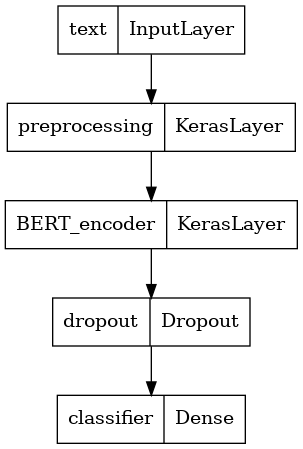

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

Now we may perform the training on the collected data from IMDb.

### Loss function

The problem at hand is a binary text classification, and the model will output a single probability value. Therefore we shall use a `BinaryCrossentropy` loss.

In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

We'll be using `AdamW` optimizer.

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
        init_lr=init_lr, num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

### Compiling the model and training

With everything ready, we can prepare the model and train it.

In [18]:
classifier_model.compile(
        optimizer=optimizer, loss=loss,
        metrics=metrics)

In [19]:
print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(
        x=train_ds, validation_data=val_ds,
        epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2
Epoch 1/5
625/625 [==============================] - 115s 180ms/step - loss: 0.6511 - binary_accuracy: 0.6039 - val_loss: 0.5046 - val_binary_accuracy: 0.7380
Epoch 2/5
625/625 [==============================] - 112s 180ms/step - loss: 0.4873 - binary_accuracy: 0.7531 - val_loss: 0.4436 - val_binary_accuracy: 0.7792
Epoch 3/5
625/625 [==============================] - 112s 179ms/step - loss: 0.4324 - binary_accuracy: 0.7943 - val_loss: 0.4298 - val_binary_accuracy: 0.7940
Epoch 4/5
625/625 [==============================] - 112s 180ms/step - loss: 0.4095 - binary_accuracy: 0.8105 - val_loss: 0.4262 - val_binary_accuracy: 0.7928
Epoch 5/5
625/625 [==============================] - 113s 181ms/step - loss: 0.3973 - binary_accuracy: 0.8159 - val_loss: 0.4333 - val_binary_accuracy: 0.7896


### Evaluate the model

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 43s 55ms/step - loss: 0.4346 - binary_accuracy: 0.7934
Loss: 0.43455561995506287
Accuracy: 0.79339998960495


### Plotting the accuracy and loss

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


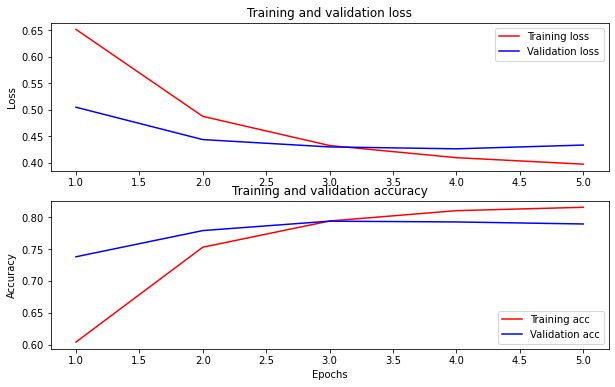

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Loading and reloading the model

We can save the model for later usage.

In [22]:
dataset_name = 'imdb'
saved_model_path = './_models/{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2021-12-09 09:50:56.472406: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [24]:
def print_my_examples(inputs, results):
    result_for_printing = \
        [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.988521
input: The movie was great!           : score: 0.945560
input: The movie was meh.             : score: 0.476977
input: The movie was okish.           : score: 0.295723
input: The movie was terrible...      : score: 0.029625

Results from the model in memory:
input: this is such an amazing movie! : score: 0.988521
input: The movie was great!           : score: 0.945560
input: The movie was meh.             : score: 0.476977
input: The movie was okish.           : score: 0.295723
input: The movie was terrible...      : score: 0.029625

